### Clean data

In [1]:
import os
import pandas as pd
import numpy as np
import qlib
from qlib.data.dataset.loader import QlibDataLoader
from qlib.data import D
from qlib.data.filter import NameDFilter
from qlib.constant import REG_CN
from qlib.utils import exists_qlib_data, init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.utils import flatten_dict
from qlib.data.dataset.loader import QlibDataLoader
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset.processor import ZScoreNorm, Fillna
from qlib.data.dataset import DatasetH, TSDatasetH

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [112]:
original_train_df = pd.read_csv('stock0.csv')
original_valid_df = pd.read_csv('stock1.csv')
original_test_df = pd.read_csv('stock2.csv')

In [113]:
train_df = original_train_df.loc[original_train_df['instrument'] == 'SH600000']
valid_df = original_valid_df.loc[original_valid_df['instrument'] == 'SH600000']
test_df = original_test_df.loc[original_test_df['instrument'] == 'SH600000']


In [114]:
train_df = train_df.dropna(axis=1, how='all').dropna(axis=0)

In [115]:
valid_df = valid_df.dropna(axis=1, how='all').dropna(axis=0)

In [116]:
test_df = test_df.dropna(axis=1, how='all').dropna(axis=0)

### Train

In [117]:
train_df['TARGET'] = train_df.OPEN0.diff().div(train_df.OPEN0.shift(1)) * 500
valid_df['TARGET'] = valid_df.OPEN0.diff().div(valid_df.OPEN0.shift(1)) * 500
test_df['TARGET'] = test_df.OPEN0.diff().div(test_df.OPEN0.shift(1)) * 500
train_df.dropna(inplace=True)
valid_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [118]:
print(train_df.TARGET.max())
print(train_df.TARGET.min())

print(valid_df.TARGET.max())
print(valid_df.TARGET.min())

print(test_df.TARGET.max())
print(test_df.TARGET.min())

82.24373175197849
-83.56454955208595
51.866256022118804
-32.69579891265163
54.97906059009949
-42.97149526802074


In [119]:
train_df.to_csv("normalized_train.csv")
valid_df.to_csv("normalized_valid.csv")
test_df.to_csv("normalized_test.csv")

### Generate dataset

In [120]:
train_df = pd.read_csv('./normalized_train.csv')
valid_df = pd.read_csv('./normalized_valid.csv')
test_df = pd.read_csv('./normalized_test.csv')

In [128]:
clean_df = pd.concat([train_df,valid_df, test_df])
clean_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [129]:
clean_df.to_csv(index=False, path_or_buf='SH600000.csv')

In [183]:
!python ../scripts/dump_bin.py dump_all --csv_path SH600000.csv --date_field_name datetime --qlib_dir ./my_data --exclude_fields instrument

2022-06-23 15:47:18.511 | INFO     | __main__:_get_all_date:272 - start get all date......

100%|██████████| 1/1 [00:03<00:00,  3.95s/it]
2022-06-23 15:47:22.464 | INFO     | __main__:_get_all_date:291 - end of get all date.

2022-06-23 15:47:22.464 | INFO     | __main__:_dump_calendars:294 - start dump calendars......
2022-06-23 15:47:22.495 | INFO     | __main__:_dump_calendars:297 - end of calendars dump.

2022-06-23 15:47:22.495 | INFO     | __main__:_dump_instruments:300 - start dump instruments......
2022-06-23 15:47:22.497 | INFO     | __main__:_dump_instruments:302 - end of instruments dump.

2022-06-23 15:47:22.497 | INFO     | __main__:_dump_features:305 - start dump features......

100%|██████████| 1/1 [00:03<00:00,  3.90s/it]
2022-06-23 15:47:26.396 | INFO     | __main__:_dump_features:312 - end of features dump.



### Clean data 2

In [2]:
import sys, site
from pathlib import Path

################################# NOTE #################################
#  Please be aware that if colab installs the latest numpy and pyqlib  #
#  in this cell, users should RESTART the runtime in order to run the  #
#  following cells successfully.                                       #
########################################################################

try:
    import qlib
except ImportError:
    # install qlib
    ! pip install --upgrade numpy
    ! pip install pyqlib
    # reload
    site.main()

scripts_dir = Path.cwd().parent.joinpath("scripts")
if not scripts_dir.joinpath("get_data.py").exists():
    # download get_data.py script
    scripts_dir = Path("~/tmp/qlib_code/scripts").expanduser().resolve()
    scripts_dir.mkdir(parents=True, exist_ok=True)
    import requests
    with requests.get("https://raw.githubusercontent.com/microsoft/qlib/main/scripts/get_data.py") as resp:
        with open(scripts_dir.joinpath("get_data.py"), "wb") as fp:
            fp.write(resp.content)

In [174]:
# use default data
# NOTE: need to download data from remote: python scripts/get_data.py qlib_data_cn --target_dir ~/.qlib/qlib_data/cn_data
provider_uri = "./my_data"  # target_dir
if not exists_qlib_data(provider_uri):
    print(f"Qlib data is not found in {provider_uri}")
    sys.path.append(str(scripts_dir))
    from get_data import GetData
    GetData().qlib_data(target_dir=provider_uri, region=REG_CN)
qlib.init(provider_uri=provider_uri, region=REG_CN)

[18744:MainThread](2022-06-23 14:57:24,153) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[18744:MainThread](2022-06-23 14:57:24,158) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[18744:MainThread](2022-06-23 14:57:24,160) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/qlib/examples/my_data')}


In [3]:
qlib.init(provider_uri='~/.qlib/qlib_data/cn_data')

[30848:MainThread](2022-06-28 15:08:40,654) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[30848:MainThread](2022-06-28 15:08:40,664) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[30848:MainThread](2022-06-28 15:08:40,665) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/.qlib/qlib_data/cn_data')}


In [189]:
D.calendar(start_time='2008-01-01', end_time='2020-08-01', freq='day')[:2]

array([Timestamp('2008-01-02 00:00:00'), Timestamp('2008-01-03 00:00:00')],
      dtype=object)

In [190]:
D.instruments(market='all')

{'market': 'all', 'filter_pipe': []}

In [241]:
instruments = D.instruments(market='all')
D.list_instruments(instruments=instruments, start_time='2008-01-01', end_time='2020-08-01', as_list=True)

['SH000300',
 'SH000903',
 'SH600000',
 'SH600004',
 'SH600006',
 'SH600007',
 'SH600008',
 'SH600009',
 'SH600010',
 'SH600011',
 'SH600012',
 'SH600015',
 'SH600016',
 'SH600017',
 'SH600018',
 'SH600019',
 'SH600020',
 'SH600021',
 'SH600022',
 'SH600023',
 'SH600025',
 'SH600026',
 'SH600027',
 'SH600028',
 'SH600029',
 'SH600030',
 'SH600031',
 'SH600033',
 'SH600035',
 'SH600036',
 'SH600037',
 'SH600038',
 'SH600039',
 'SH600048',
 'SH600050',
 'SH600051',
 'SH600052',
 'SH600053',
 'SH600054',
 'SH600055',
 'SH600056',
 'SH600057',
 'SH600058',
 'SH600059',
 'SH600060',
 'SH600061',
 'SH600062',
 'SH600063',
 'SH600064',
 'SH600066',
 'SH600067',
 'SH600068',
 'SH600070',
 'SH600071',
 'SH600072',
 'SH600073',
 'SH600075',
 'SH600076',
 'SH600077',
 'SH600078',
 'SH600079',
 'SH600080',
 'SH600081',
 'SH600082',
 'SH600083',
 'SH600084',
 'SH600085',
 'SH600088',
 'SH600089',
 'SH600090',
 'SH600091',
 'SH600093',
 'SH600094',
 'SH600095',
 'SH600096',
 'SH600097',
 'SH600098',

In [196]:
nameDFilter = NameDFilter(name_rule_re='SH600000')
instruments = D.instruments(market='csi300', filter_pipe=[nameDFilter])
fields = ['$close', '$volume', 'Ref($close, 1)', 'Mean($close, 3)', '$high-$low']
D.features(instruments, fields, start_time='2008-01-01', end_time='2020-08-01', freq='day').head()

$close      $volume  Ref($close, 1)  \
instrument datetime                                             
SH600000   2008-01-02  10.472238   67285696.0       10.325569   
           2008-01-03   9.948137  108072488.0       10.472238   
           2008-01-04  10.366634   71205600.0        9.948137   
           2008-01-07  10.949405  116610240.0       10.366634   
           2008-01-08  11.027629   82458224.0       10.949405   

                       Mean($close, 3)  $high-$low  
instrument datetime                                 
SH600000   2008-01-02        10.294279    0.633614  
           2008-01-03        10.248648    0.776373  
           2008-01-04        10.262337    0.702060  
           2008-01-07        10.421392    0.737262  
           2008-01-08        10.781222    0.232717

In [247]:
# nameDFilter = NameDFilter(name_rule_re='SH000300')
# instruments = D.instruments(market='csi300', filter_pipe=[nameDFilter])
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money']
# data = D.features(instruments, fields, start_time='2008-01-01', end_time='2020-08-01', freq='day')
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money']])
df = qdl.load(instruments = ['SH000300'], start_time='2008-01-01', end_time='2020-08-01')

In [260]:
df['target'] = df['close'].diff().div(df['close'].shift(1)) * 1000

In [262]:
print(df['target'].max())
print(df['target'].min())

93.41819
-87.47919


In [264]:
df.to_csv(path_or_buf='SH000300.csv')

In [265]:
!python ../scripts/dump_bin.py dump_all --csv_path SH000300.csv --date_field_name datetime --qlib_dir ./my_data --exclude_fields instrument

2022-06-23 19:30:41.716 | INFO     | __main__:_get_all_date:272 - start get all date......

100%|██████████| 1/1 [00:03<00:00,  3.39s/it]
2022-06-23 19:30:45.110 | INFO     | __main__:_get_all_date:291 - end of get all date.

2022-06-23 19:30:45.110 | INFO     | __main__:_dump_calendars:294 - start dump calendars......
2022-06-23 19:30:45.144 | INFO     | __main__:_dump_calendars:297 - end of calendars dump.

2022-06-23 19:30:45.144 | INFO     | __main__:_dump_instruments:300 - start dump instruments......
2022-06-23 19:30:45.146 | INFO     | __main__:_dump_instruments:302 - end of instruments dump.

2022-06-23 19:30:45.146 | INFO     | __main__:_dump_features:305 - start dump features......

100%|██████████| 1/1 [00:03<00:00,  3.84s/it]
2022-06-23 19:30:48.986 | INFO     | __main__:_dump_features:312 - end of features dump.



### Prepare dataset

In [776]:
df = pd.read_csv("SH000300.csv", index_col=None)

In [777]:
df

datetime instrument      open     close      high       low  volumn  \
0     2008-01-02   SH000300  5.443442  5.479401  5.499578  5.375970     NaN   
1     2008-01-03   SH000300  5.475381  5.516977  5.517628  5.409039     NaN   
2     2008-01-04   SH000300  5.525728  5.579676  5.595377  5.517415     NaN   
3     2008-01-07   SH000300  5.576410  5.653893  5.666674  5.551033     NaN   
4     2008-01-08   SH000300  5.673593  5.624854  5.729220  5.581284     NaN   
...          ...        ...       ...       ...       ...       ...     ...   
3056  2020-07-27   SH000300  4.614424  4.607749  4.637939  4.560934     NaN   
3057  2020-07-28   SH000300  4.647656  4.648256  4.670631  4.617141     NaN   
3058  2020-07-29   SH000300  4.638997  4.760946  4.762523  4.628507     NaN   
3059  2020-07-30   SH000300  4.771884  4.737686  4.787014  4.731194     NaN   
3060  2020-07-31   SH000300  4.733646  4.777267  4.824846  4.702897     NaN   

        factor  adjclose    change        money     target  
0     0.001018   5385.10  0.008773  100618070.0        NaN  
1     0.001018   5422.03  0.006858  138364600.0   6.857808  
2     0.001018   5483.65  0.011365  120947740.0  11.364709  
3     0.001018   5556.59  0.013301  125346770.0  13.301367  
4     0.001018   5528.05 -0.005136  150567000.0  -5.136259  
...        ...       ...       ...          ...        ...  
3056  0.001018   4528.45  0.005074  307179940.0   5.073759  
3057  0.001018   4568.26  0.008791  297963740.0   8.791025  
3058  0.001018   4679.01  0.024243  356569200.0  24.243391  
3059  0.001018   4656.15 -0.004886  329683100.0  -4.885608  
3060  0.001018   4695.05  0.008355  357267900.0   8.354565  

[3061 rows x 12 columns]

In [774]:
df.loc[df.target < 1.0, 'target'] = 1.0
print(df.target.min())
print(df.target.max())

1.0
93.41819


In [778]:
df.loc[df.target > -1.0, 'target'] = 1.0
df.target = df['target'].abs()
print(df.target.min())
print(df.target.max())

1.0
87.47919


In [2]:
if not os.path.exists("dataset/dataset_benefit/"):
    os.mkdir("dataset/dataset_benefit/")
df.to_csv("dataset/dataset_benefit/SH000300.csv")

NameError: name 'df' is not defined

In [779]:
if not os.path.exists("dataset/dataset_risk/"):
    os.mkdir("dataset/dataset_risk/")
df.to_csv("dataset/dataset_risk/SH000300.csv")

In [780]:
!python ../scripts/dump_bin.py dump_all --csv_path dataset/dataset_benefit/SH000300.csv --date_field_name datetime --qlib_dir dataset/dataset_benefit_bin --exclude_fields instrument

2022-06-24 19:06:38.530 | INFO     | __main__:_get_all_date:272 - start get all date......

100%|██████████| 1/1 [00:03<00:00,  3.80s/it]
2022-06-24 19:06:42.330 | INFO     | __main__:_get_all_date:291 - end of get all date.

2022-06-24 19:06:42.330 | INFO     | __main__:_dump_calendars:294 - start dump calendars......
2022-06-24 19:06:42.359 | INFO     | __main__:_dump_calendars:297 - end of calendars dump.

2022-06-24 19:06:42.359 | INFO     | __main__:_dump_instruments:300 - start dump instruments......
2022-06-24 19:06:42.361 | INFO     | __main__:_dump_instruments:302 - end of instruments dump.

2022-06-24 19:06:42.362 | INFO     | __main__:_dump_features:305 - start dump features......

100%|██████████| 1/1 [00:04<00:00,  4.02s/it]
2022-06-24 19:06:46.381 | INFO     | __main__:_dump_features:312 - end of features dump.



In [781]:
!python ../scripts/dump_bin.py dump_all --csv_path dataset/dataset_risk/SH000300.csv --date_field_name datetime --qlib_dir dataset/dataset_risk_bin --exclude_fields instrument

2022-06-24 19:06:53.394 | INFO     | __main__:_get_all_date:272 - start get all date......

100%|██████████| 1/1 [00:03<00:00,  3.88s/it]
2022-06-24 19:06:57.274 | INFO     | __main__:_get_all_date:291 - end of get all date.

2022-06-24 19:06:57.274 | INFO     | __main__:_dump_calendars:294 - start dump calendars......
2022-06-24 19:06:57.303 | INFO     | __main__:_dump_calendars:297 - end of calendars dump.

2022-06-24 19:06:57.303 | INFO     | __main__:_dump_instruments:300 - start dump instruments......
2022-06-24 19:06:57.305 | INFO     | __main__:_dump_instruments:302 - end of instruments dump.

2022-06-24 19:06:57.305 | INFO     | __main__:_dump_features:305 - start dump features......

100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]
2022-06-24 19:07:01.009 | INFO     | __main__:_dump_features:312 - end of features dump.



### Train 1 (benefit)

In [36]:
# use default data
# NOTE: need to download data from remote: python scripts/get_data.py qlib_data_cn --target_dir ~/.qlib/qlib_data/cn_data
provider_uri = "./dataset/dataset_benefit_bin/"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_CN)

[10208:MainThread](2022-06-27 18:58:16,438) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[10208:MainThread](2022-06-27 18:58:16,448) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[10208:MainThread](2022-06-27 18:58:16,449) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/qlib/examples/dataset/dataset_benefit_bin')}


In [37]:
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money', '$target']
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money', 'target']])

In [38]:
qdl.load(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01')

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     NaN   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     NaN   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     NaN   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     NaN   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     NaN   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     NaN   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     NaN   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     NaN   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     NaN   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     NaN   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0        NaN  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0   6.857808  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  11.364709  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  13.301367  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0   1.000000  
...                         ...          ...       ...          ...        ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0   5.073759  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0   8.791025  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  24.243391  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0   1.000000  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0   8.354565  

[3061 rows x 10 columns]

In [39]:
dh = DataHandlerLP(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01',
             infer_processors=[Fillna()],
             data_loader=qdl)

[10208:MainThread](2022-06-27 18:58:22,351) INFO - qlib.timer - [log.py:113] - Time cost: 0.021s | Loading data Done
[10208:MainThread](2022-06-27 18:58:22,354) INFO - qlib.timer - [log.py:113] - Time cost: 0.001s | Fillna Done
[10208:MainThread](2022-06-27 18:58:22,356) INFO - qlib.timer - [log.py:113] - Time cost: 0.003s | fit & process data Done
[10208:MainThread](2022-06-27 18:58:22,357) INFO - qlib.timer - [log.py:113] - Time cost: 0.027s | Init data Done


In [40]:
dh.fetch()

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     0.0   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     0.0   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     0.0   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     0.0   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     0.0   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     0.0   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     0.0   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     0.0   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     0.0   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     0.0   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0   0.000000  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0   6.857808  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  11.364709  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  13.301367  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0   1.000000  
...                         ...          ...       ...          ...        ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0   5.073759  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0   8.791025  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  24.243391  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0   1.000000  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0   8.354565  

[3061 rows x 10 columns]

In [41]:
ds = DatasetH(dh, segments={"train": ("2008-01-01", "2016-12-31"), "valid": ("2017-01-01", "2018-12-31"), "test": ("2019-01-01", "2020-08-01")})

In [9]:
ds.prepare('train')

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     0.0   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     0.0   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     0.0   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     0.0   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     0.0   
...                         ...       ...       ...       ...     ...   
2016-12-26 sh000300    3.350889  3.380580  3.380600  3.324260     0.0   
2016-12-27 sh000300    3.377334  3.374465  3.388547  3.373895     0.0   
2016-12-28 sh000300    3.373813  3.359711  3.378697  3.350838     0.0   
2016-12-29 sh000300    3.354776  3.355508  3.370110  3.345679     0.0   
2016-12-30 sh000300    3.360433  3.368044  3.371575  3.353463     0.0   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0   0.000000  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0   6.857808  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  11.364709  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  13.301367  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0   1.000000  
...                         ...          ...       ...          ...        ...  
2016-12-26 sh000300    0.001018  3322.399902  0.004475   97165440.0   4.474492  
2016-12-27 sh000300    0.001018  3316.389893 -0.001809   81011336.0   1.000000  
2016-12-28 sh000300    0.001018  3301.889893 -0.004372   73016456.0   1.000000  
2016-12-29 sh000300    0.001018  3297.760010 -0.001251   77303352.0   1.000000  
2016-12-30 sh000300    0.001018  3310.080078  0.003736   78268368.0   3.735890  

[2190 rows x 10 columns]

In [10]:
ds.prepare('valid')

open     close      high       low  volumn  \
datetime   instrument                                                   
2017-01-03 sh000300    3.371982  3.400757  3.403840  3.371982     0.0   
2017-01-04 sh000300    3.399058  3.427294  3.428576  3.396605     0.0   
2017-01-05 sh000300    3.427324  3.426765  3.432483  3.420324     0.0   
2017-01-06 sh000300    3.425808  3.406292  3.427864  3.405499     0.0   
2017-01-09 sh000300    3.404339  3.422807  3.425167  3.402914     0.0   
...                         ...       ...       ...       ...     ...   
2018-12-24 sh000300    3.068305  3.091403  3.093591  3.059993     0.0   
2018-12-25 sh000300    3.059535  3.070117  3.083202  3.016799     0.0   
2018-12-26 sh000300    3.065629  3.054600  3.082103  3.048953     0.0   
2018-12-27 sh000300    3.096236  3.042878  3.100591  3.042878     0.0   
2018-12-28 sh000300    3.047243  3.063371  3.077311  3.037088     0.0   

                         factor     adjclose    change       money    target  
datetime   instrument                                                         
2017-01-03 sh000300    0.001018  3342.229980  0.009713  89146984.0  9.712740  
2017-01-04 sh000300    0.001018  3368.310059  0.007803  99730720.0  7.803175  
2017-01-05 sh000300    0.001018  3367.790039 -0.000154  92786192.0  1.000000  
2017-01-06 sh000300    0.001018  3347.669922 -0.005974  92667056.0  1.000000  
2017-01-09 sh000300    0.001018  3363.899902  0.004848  89455648.0  4.848175  
...                         ...          ...       ...         ...       ...  
2018-12-24 sh000300    0.001018  3038.199951  0.002905  64999380.0  2.904849  
2018-12-25 sh000300    0.001018  3017.280029 -0.006886  81821720.0  1.000000  
2018-12-26 sh000300    0.001018  3002.030029 -0.005054  59600696.0  1.000000  
2018-12-27 sh000300    0.001018  2990.510010 -0.003837  82580480.0  1.000000  
2018-12-28 sh000300    0.001018  3010.649902  0.006735  79513744.0  6.734674  

[487 rows x 10 columns]

In [11]:
ds.prepare('test')

open     close      high       low  volumn  \
datetime   instrument                                                   
2019-01-02 sh000300    3.069903  3.021541  3.071643  3.010297     0.0   
2019-01-03 sh000300    3.014907  3.016758  3.052982  3.004966     0.0   
2019-01-04 sh000300    2.991677  3.089032  3.089989  2.987240     0.0   
2019-01-07 sh000300    3.108650  3.107785  3.115366  3.089073     0.0   
2019-01-08 sh000300    3.103277  3.101069  3.109016  3.091739     0.0   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     0.0   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     0.0   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     0.0   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     0.0   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     0.0   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2019-01-02 sh000300    0.001018  2969.540039 -0.013655   77438288.0   1.000000  
2019-01-03 sh000300    0.001018  2964.840088 -0.001583   78007304.0   1.000000  
2019-01-04 sh000300    0.001018  3035.870117  0.023957  109017224.0  23.957415  
2019-01-07 sh000300    0.001018  3054.300049  0.006071  107554960.0   6.070773  
2019-01-08 sh000300    0.001018  3047.699951 -0.002161   81023296.0   1.000000  
...                         ...          ...       ...          ...        ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0   5.073759  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0   8.791025  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  24.243391  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0   1.000000  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0   8.354565  

[384 rows x 10 columns]

In [42]:
x_train, y_train = ds.prepare('train')[['open', 'close', 'high', 'low']], ds.prepare('train')[['target']]
x_test, y_test = ds.prepare('test')[['open', 'close', 'high', 'low']], ds.prepare('test')[['target']]
x_valid, y_valid = ds.prepare('valid')[['open', 'close', 'high', 'low']], ds.prepare('valid')[['target']]

benefit_datasets = [x_train, y_train, x_test, y_test, x_valid, y_valid]

In [13]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

In [32]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1', 'auc', 'binary'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    "max_depth": 20,
}

In [33]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=5,
                valid_sets=lgb_valid,
                callbacks=[lgb.early_stopping(stopping_rounds=50)])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: -1.95819	valid_0's l1: 5.32918	valid_0's auc: 

In [805]:
y_test.max()
y_test.min()
y_test.isna()

target
datetime   instrument        
2019-01-02 sh000300     False
2019-01-03 sh000300     False
2019-01-04 sh000300     False
2019-01-07 sh000300     False
2019-01-08 sh000300     False
...                       ...
2020-07-27 sh000300     False
2020-07-28 sh000300     False
2020-07-29 sh000300     False
2020-07-30 sh000300     False
2020-07-31 sh000300     False

[384 rows x 1 columns]

In [761]:
y_test

target
datetime   instrument           
2019-01-02 sh000300     1.000000
2019-01-03 sh000300     1.000000
2019-01-04 sh000300    23.957415
2019-01-07 sh000300     6.070773
2019-01-08 sh000300     1.000000
...                          ...
2020-07-27 sh000300     5.073759
2020-07-28 sh000300     8.791025
2020-07-29 sh000300    24.243391
2020-07-30 sh000300     1.000000
2020-07-31 sh000300     8.354565

[384 rows x 1 columns]

In [34]:
# predict
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

The RMSE of prediction is: 8.360566379509061


In [30]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

(0.0, 60.0)

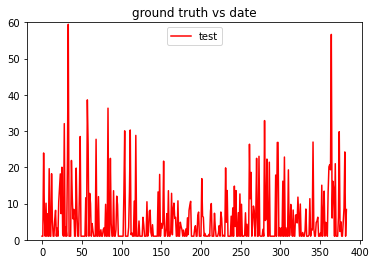

In [35]:
# x = len(y_test)
# X_Y_Spline = make_interp_spline(range(x), y_test['target'])
# x = np.linspace(0, len(y_test), len(y_test))
# y = X_Y_Spline(x)

plt.plot(range(len(y_pred.tolist())), y_pred.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date")
plt.ylim([0, 20])
plt.figure()
plt.plot(range(len(y_pred.tolist())), y_test, 'r', label='test')
plt.legend()
plt.title("ground truth vs date")
plt.ylim([0, 60])

# plt.show()

In [25]:
y_test_benefit = y_test
y_pred_benefit = y_pred

### Train 2 (risk)

In [43]:
provider_uri = "./dataset/dataset_risk_bin/"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_CN)

[10208:MainThread](2022-06-27 18:59:46,766) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[10208:MainThread](2022-06-27 18:59:46,769) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[10208:MainThread](2022-06-27 18:59:46,770) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/qlib/examples/dataset/dataset_risk_bin')}


In [44]:
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money', '$target']
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money', 'target']])
qdl.load(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01')

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     NaN   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     NaN   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     NaN   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     NaN   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     NaN   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     NaN   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     NaN   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     NaN   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     NaN   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     NaN   

                         factor     adjclose    change        money    target  
datetime   instrument                                                          
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0       NaN  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0  1.000000  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  1.000000  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  1.000000  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0  5.136259  
...                         ...          ...       ...          ...       ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0  1.000000  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0  1.000000  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  1.000000  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0  4.885608  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0  1.000000  

[3061 rows x 10 columns]

In [45]:
dh = DataHandlerLP(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01',
             infer_processors=[Fillna()],
             data_loader=qdl)
dh.fetch()

[10208:MainThread](2022-06-27 18:59:50,778) INFO - qlib.timer - [log.py:113] - Time cost: 0.020s | Loading data Done
[10208:MainThread](2022-06-27 18:59:50,781) INFO - qlib.timer - [log.py:113] - Time cost: 0.001s | Fillna Done
[10208:MainThread](2022-06-27 18:59:50,783) INFO - qlib.timer - [log.py:113] - Time cost: 0.003s | fit & process data Done
[10208:MainThread](2022-06-27 18:59:50,785) INFO - qlib.timer - [log.py:113] - Time cost: 0.028s | Init data Done


open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     0.0   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     0.0   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     0.0   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     0.0   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     0.0   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     0.0   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     0.0   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     0.0   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     0.0   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     0.0   

                         factor     adjclose    change        money    target  
datetime   instrument                                                          
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0  0.000000  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0  1.000000  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  1.000000  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  1.000000  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0  5.136259  
...                         ...          ...       ...          ...       ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0  1.000000  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0  1.000000  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  1.000000  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0  4.885608  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0  1.000000  

[3061 rows x 10 columns]

In [46]:
ds = DatasetH(dh, segments={"train": ("2008-01-01", "2016-12-31"), "valid": ("2017-01-01", "2018-12-31"), "test": ("2019-01-01", "2020-08-01")})

In [819]:
ds.prepare('train')

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     0.0   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     0.0   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     0.0   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     0.0   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     0.0   
...                         ...       ...       ...       ...     ...   
2016-12-26 sh000300    3.350889  3.380580  3.380600  3.324260     0.0   
2016-12-27 sh000300    3.377334  3.374465  3.388547  3.373895     0.0   
2016-12-28 sh000300    3.373813  3.359711  3.378697  3.350838     0.0   
2016-12-29 sh000300    3.354776  3.355508  3.370110  3.345679     0.0   
2016-12-30 sh000300    3.360433  3.368044  3.371575  3.353463     0.0   

                         factor     adjclose    change        money    target  
datetime   instrument                                                          
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0  0.000000  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0  1.000000  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  1.000000  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  1.000000  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0  5.136259  
...                         ...          ...       ...          ...       ...  
2016-12-26 sh000300    0.001018  3322.399902  0.004475   97165440.0  1.000000  
2016-12-27 sh000300    0.001018  3316.389893 -0.001809   81011336.0  1.808920  
2016-12-28 sh000300    0.001018  3301.889893 -0.004372   73016456.0  4.372195  
2016-12-29 sh000300    0.001018  3297.760010 -0.001251   77303352.0  1.250812  
2016-12-30 sh000300    0.001018  3310.080078  0.003736   78268368.0  1.000000  

[2190 rows x 10 columns]

In [820]:
ds.prepare('valid')

open     close      high       low  volumn  \
datetime   instrument                                                   
2017-01-03 sh000300    3.371982  3.400757  3.403840  3.371982     0.0   
2017-01-04 sh000300    3.399058  3.427294  3.428576  3.396605     0.0   
2017-01-05 sh000300    3.427324  3.426765  3.432483  3.420324     0.0   
2017-01-06 sh000300    3.425808  3.406292  3.427864  3.405499     0.0   
2017-01-09 sh000300    3.404339  3.422807  3.425167  3.402914     0.0   
...                         ...       ...       ...       ...     ...   
2018-12-24 sh000300    3.068305  3.091403  3.093591  3.059993     0.0   
2018-12-25 sh000300    3.059535  3.070117  3.083202  3.016799     0.0   
2018-12-26 sh000300    3.065629  3.054600  3.082103  3.048953     0.0   
2018-12-27 sh000300    3.096236  3.042878  3.100591  3.042878     0.0   
2018-12-28 sh000300    3.047243  3.063371  3.077311  3.037088     0.0   

                         factor     adjclose    change       money    target  
datetime   instrument                                                         
2017-01-03 sh000300    0.001018  3342.229980  0.009713  89146984.0  1.000000  
2017-01-04 sh000300    0.001018  3368.310059  0.007803  99730720.0  1.000000  
2017-01-05 sh000300    0.001018  3367.790039 -0.000154  92786192.0  1.000000  
2017-01-06 sh000300    0.001018  3347.669922 -0.005974  92667056.0  5.974302  
2017-01-09 sh000300    0.001018  3363.899902  0.004848  89455648.0  1.000000  
...                         ...          ...       ...         ...       ...  
2018-12-24 sh000300    0.001018  3038.199951  0.002905  64999380.0  1.000000  
2018-12-25 sh000300    0.001018  3017.280029 -0.006886  81821720.0  6.885627  
2018-12-26 sh000300    0.001018  3002.030029 -0.005054  59600696.0  5.054204  
2018-12-27 sh000300    0.001018  2990.510010 -0.003837  82580480.0  3.837442  
2018-12-28 sh000300    0.001018  3010.649902  0.006735  79513744.0  1.000000  

[487 rows x 10 columns]

In [821]:
ds.prepare('test')

open     close      high       low  volumn  \
datetime   instrument                                                   
2019-01-02 sh000300    3.069903  3.021541  3.071643  3.010297     0.0   
2019-01-03 sh000300    3.014907  3.016758  3.052982  3.004966     0.0   
2019-01-04 sh000300    2.991677  3.089032  3.089989  2.987240     0.0   
2019-01-07 sh000300    3.108650  3.107785  3.115366  3.089073     0.0   
2019-01-08 sh000300    3.103277  3.101069  3.109016  3.091739     0.0   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     0.0   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     0.0   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     0.0   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     0.0   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     0.0   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2019-01-02 sh000300    0.001018  2969.540039 -0.013655   77438288.0  13.654914  
2019-01-03 sh000300    0.001018  2964.840088 -0.001583   78007304.0   1.582703  
2019-01-04 sh000300    0.001018  3035.870117  0.023957  109017224.0   1.000000  
2019-01-07 sh000300    0.001018  3054.300049  0.006071  107554960.0   1.000000  
2019-01-08 sh000300    0.001018  3047.699951 -0.002161   81023296.0   2.160875  
...                         ...          ...       ...          ...        ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0   1.000000  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0   1.000000  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0   1.000000  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0   4.885608  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0   1.000000  

[384 rows x 10 columns]

In [47]:
x_train, y_train = ds.prepare('train')[['open', 'close', 'high', 'low']], ds.prepare('train')[['target']]
x_test, y_test = ds.prepare('test')[['open', 'close', 'high', 'low']], ds.prepare('test')[['target']]
x_valid, y_valid = ds.prepare('valid')[['open', 'close', 'high', 'low']], ds.prepare('valid')[['target']]

risk_datasets = [x_train, y_train, x_test, y_test, x_valid, y_valid]

In [823]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

In [824]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1', 'auc', 'binary'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    "max_depth": 20,
}

In [825]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_valid,
                callbacks=[lgb.early_stopping(stopping_rounds=20)])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 5.39544	valid_0's auc: 1	valid_0's binary_logloss: -1.91694	valid_0's l2: 46.0968


In [826]:
# y_test.max()
y_test.min()
# y_test.isna()

target    1.0
dtype: float32

In [827]:
# predict
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

The RMSE of prediction is: 8.726777114204307


In [828]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

(0.0, 60.0)

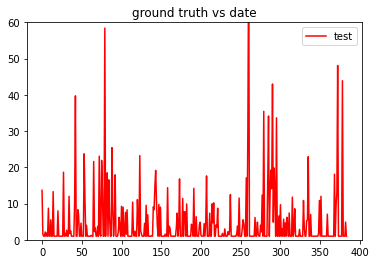

In [829]:
plt.plot(range(len(y_pred.tolist())), y_pred.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date")
plt.ylim([0,30])
plt.figure()
plt.plot(range(len(y_pred.tolist())), y_test.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date")
plt.ylim([0, 60])

In [830]:
y_test_risk = y_test
y_pred_risk = y_pred

### draw graph

(0.0, 100.0)

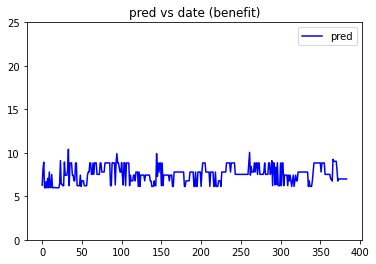

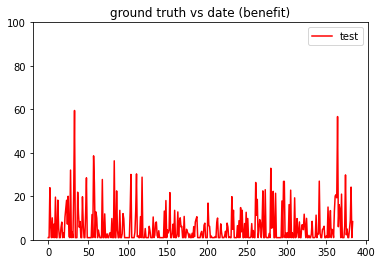

In [833]:
plt.plot(range(len(y_pred_benefit.tolist())), y_pred_benefit.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date (benefit)")
plt.ylim([0, 25])
plt.figure()
plt.plot(range(len(y_pred_benefit.tolist())), y_test_benefit.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date (benefit)")
plt.ylim([0, 100])


(0.0, 100.0)

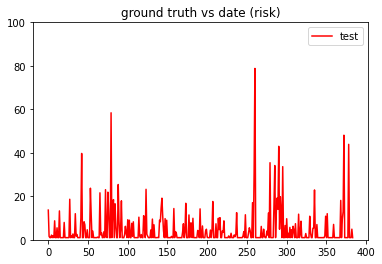

In [834]:
plt.plot(range(len(y_pred_risk.tolist())), y_pred_risk.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date (risk)")
plt.ylim([0, 25])
plt.figure()
plt.plot(range(len(y_pred_risk.tolist())), y_test_risk.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date (risk)")
plt.ylim([0, 100])

(0.0, 100.0)

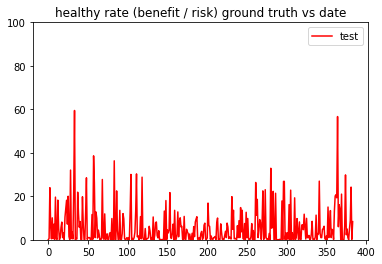

In [835]:
plt.plot(range(len(y_pred_benefit.tolist())), (y_pred_benefit / y_pred_risk).tolist(), 'b', label='pred')
plt.legend()
plt.title("healthy rate (benefit / risk) pred vs date")
plt.ylim([0, 25])
plt.figure()
plt.plot(range(len(y_pred_benefit.tolist())), y_test_benefit.target.div(y_test_risk.target), 'r', label='test')
plt.legend()
plt.title("healthy rate (benefit / risk) ground truth vs date")
plt.ylim([0, 100])

In [673]:
y_test_benefit.target.div(y_test_risk.target)

datetime    instrument
2017-01-03  sh000300       9.712740
2017-01-04  sh000300       7.803175
2017-01-05  sh000300       1.000000
2017-01-06  sh000300       0.167384
2017-01-09  sh000300       4.848175
                            ...    
2020-07-27  sh000300       5.073759
2020-07-28  sh000300       8.791025
2020-07-29  sh000300      24.243391
2020-07-30  sh000300       0.204683
2020-07-31  sh000300       8.354565
Name: target, Length: 871, dtype: float32

In [671]:
y_test_benefit.target

datetime    instrument
2017-01-03  sh000300       9.712740
2017-01-04  sh000300       7.803175
2017-01-05  sh000300       1.000000
2017-01-06  sh000300       1.000000
2017-01-09  sh000300       4.848175
                            ...    
2020-07-27  sh000300       5.073759
2020-07-28  sh000300       8.791025
2020-07-29  sh000300      24.243391
2020-07-30  sh000300       1.000000
2020-07-31  sh000300       8.354565
Name: target, Length: 871, dtype: float32

In [674]:
y_test_risk.target

datetime    instrument
2017-01-03  sh000300      1.000000
2017-01-04  sh000300      1.000000
2017-01-05  sh000300      1.000000
2017-01-06  sh000300      5.974302
2017-01-09  sh000300      1.000000
                            ...   
2020-07-27  sh000300      1.000000
2020-07-28  sh000300      1.000000
2020-07-29  sh000300      1.000000
2020-07-30  sh000300      4.885608
2020-07-31  sh000300      1.000000
Name: target, Length: 871, dtype: float32

In [676]:
df.target

0            NaN
1       1.000000
2       1.000000
3       1.000000
4       5.136259
          ...   
3056    1.000000
3057    1.000000
3058    1.000000
3059    4.885608
3060    1.000000
Name: target, Length: 3061, dtype: float64

### Inspect data

In [48]:
x_train_benefit, y_train_benefit, x_test_benefit, y_test_benefit, x_valid_benefit, y_valid_benefit = benefit_datasets
x_train_risk, y_train_risk, x_test_risk, y_test_risk, x_valid_risk, y_valid_risk = risk_datasets

In [62]:
print(y_train_benefit.target.value_counts())
print(y_train_benefit.target.size)

1.000000     1144
0.000000        1
1.773502        1
7.027663        1
2.489593        1
             ... 
17.588896       1
11.578769       1
7.887447        1
3.106473        1
3.735890        1
Name: target, Length: 1047, dtype: int64
2190


In [64]:
print(y_train_risk.target.value_counts())
print(y_train_risk.target.size)

1.000000     1206
9.887625        1
18.702919       1
3.320461        1
10.290053       1
             ... 
32.888340       1
9.797318        1
5.273828        1
11.805923       1
1.250812        1
Name: target, Length: 985, dtype: int64
2190


In [79]:
benefit_dist = {(1): 0}
for i in range(1, 21):
    benefit_dist[((i - 1) * 5 + 1, i * 5)] = 0

In [70]:
risk_dist = {(1): 0}
for i in range(1, 21):
    risk_dist[((i - 1) * 5 + 1, i * 5)] = 0

In [71]:
print(benefit_dist)
print(risk_dist)

{1: 0, (1, 5): 0, (6, 10): 0, (11, 15): 0, (16, 20): 0, (21, 25): 0, (26, 30): 0, (31, 35): 0, (36, 40): 0, (41, 45): 0, (46, 50): 0, (51, 55): 0, (56, 60): 0, (61, 65): 0, (66, 70): 0, (71, 75): 0, (76, 80): 0, (81, 85): 0, (86, 90): 0, (91, 95): 0, (96, 100): 0}
{1: 0, (1, 5): 0, (6, 10): 0, (11, 15): 0, (16, 20): 0, (21, 25): 0, (26, 30): 0, (31, 35): 0, (36, 40): 0, (41, 45): 0, (46, 50): 0, (51, 55): 0, (56, 60): 0, (61, 65): 0, (66, 70): 0, (71, 75): 0, (76, 80): 0, (81, 85): 0, (86, 90): 0, (91, 95): 0, (96, 100): 0}


In [80]:
for i in range(y_train_benefit.target.size):
    num = y_train_benefit.target[i]
    if num == 1:
        benefit_dist[(1)] += 1
    else:
        num = int(num)
        benefit_dist[(num // 5 * 5 + 1, (num // 5 + 1) * 5)] += 1
print(benefit_dist)


{1: 1144, (1, 5): 305, (6, 10): 235, (11, 15): 168, (16, 20): 108, (21, 25): 75, (26, 30): 49, (31, 35): 45, (36, 40): 19, (41, 45): 13, (46, 50): 11, (51, 55): 6, (56, 60): 2, (61, 65): 3, (66, 70): 2, (71, 75): 1, (76, 80): 1, (81, 85): 1, (86, 90): 0, (91, 95): 2, (96, 100): 0}


In [81]:
for i in range(y_train_risk.target.size):
    num = y_train_risk.target[i]
    if num == 1:
        risk_dist[(1)] += 1
    else:
        num = int(num)
        risk_dist[(num // 5 * 5 + 1, (num // 5 + 1) * 5)] += 1
print(risk_dist)


{1: 1206, (1, 5): 263, (6, 10): 249, (11, 15): 144, (16, 20): 103, (21, 25): 66, (26, 30): 42, (31, 35): 32, (36, 40): 21, (41, 45): 11, (46, 50): 15, (51, 55): 13, (56, 60): 2, (61, 65): 6, (66, 70): 5, (71, 75): 6, (76, 80): 3, (81, 85): 1, (86, 90): 2, (91, 95): 0, (96, 100): 0}


Text(0.5, 1.0, 'risk data distribution')

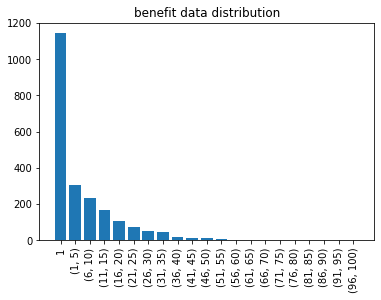

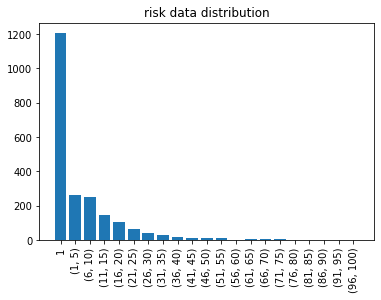

In [88]:
plt.figure()
plt.bar(list(map(str, benefit_dist.keys())), benefit_dist.values())
plt.xticks(rotation = 90)
plt.title("benefit data distribution")
plt.figure()
plt.bar(list(map(str, risk_dist.keys())), risk_dist.values())
plt.xticks(rotation = 90)
plt.title("risk data distribution")